In [2]:
import os
import sys
import glob
import yaml
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
palette = sns.color_palette()
pd.options.mode.copy_on_write = True
scripts_dir = os.path.abspath(os.path.join(os.getcwd(), "../scripts"))
sys.path.append(scripts_dir)
workflows_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(workflows_dir)

pretty_print = {"string": "STRING",
      "gseapy": "GSEApy",
      "clusterProfiler": "ClusterProfiler",
      "neg_signed_logpval": "signed logPValue",
      "logFC": "logFC",
      "s2n": "Signal-to-noise"}

# Define params

- `input_file`: Path (relative to project root) to a csv file containing a table with gene identifiers and ranking metric(s). Input files should be put in the `resources` folder.
  
- `project_name`: A string to tag output files. Results will be saved in `results/{project_name}/some_filename.{project_name}.csv`

- `metrics`: A list of strings specifying columns in the input table that are used to rank the genes.

- `libraries`: A list of libraries to be included. Currently supported: "KEGG", "GO", or path to .gmt file. If .gmt file is provided, `keytype_gmt` must be specified.

- `tools`: A list of strings specifying the tools to be used. Currently supported : "clusterProfiler", "gseapy", "string". If results from [STRING](https://string-db.org/cgi/input?sessionId=b9myRH3ZDO2O&input_page_active_form=proteins_with_values) are to be used, the tsv files must be downloaded from the web tool and saved in the results folder (see "Format STRING table").
  
- `keytype`: String specifying the [type of gene identifier](https://www.bioconductor.org/help/course-materials/2014/useR2014/Integration.html) in the input file, e.g. "ENSEMBLE" or "SYMBOL".

- `keytype_gmt`: (Optional) String specifying the type of gene identifier in the provided .gmt file (if .gmt file is provded in `libraries`).

- `organismKEGG`: Currently supported: "hsa" for human and "mmu" for mouse.

- `qval`: Q-value threshold to define significant terms. This value can be easily changed later on in downstream inspection of results.

In [8]:
#### User-defined variables ####

input_file = "resources/testdata/BRCA.N3.qlf.csv"
project_name = "test"

metrics = ['logFC', 'neg_signed_logpval', 's2n']
libraries = ["KEGG", "GO_STRING_human.gmt"]
tools = ["clusterProfiler", "gseapy", "string"]

keytype = "ENSEMBL"
keytype_gmt = "SYMBOL"
organismKEGG = "hsa"
qval = 0.05
fdr = 0.05
fig_formats = ["pdf"]

# Table with normalized expression values
input_file_expression = "../../resources/testdata/BRCA.N3.norm.csv"
control_tag = "N"
case_tag = "T"

# Lollipop plots
depth_cutoff_lollipop = 6
x_val_lollipop = "NegSignedlogFDR"  # or SignedDepth

go_sem_sim = False
go_sem_sim_max_distance = 0.2

In [5]:
# Manuscript

#### User-defined variables ####

input_file = "resources/GEO/GATB.edgerqlf.lfc0.csv"
project_name = "GATB.QLF"

# Table with normalized expression values
input_file_expression = "../../resources/GEO/GATB.norm.csv"
control_tag = "_Control"
case_tag = "_Active"

## Create config.yaml file

In [9]:
lib_names = {"GO" if lib.startswith("GO_") else os.path.splitext(os.path.basename(lib))[0]: lib for lib in libraries}
for lib in lib_names:
    assert "." not in lib

# Create configuration dictionary
config_data = {
    'input_file': input_file,
    'project_name': project_name,
    'metrics': metrics,
    'keytype': keytype,
    'keytype_gmt': keytype_gmt if "keytype_gmt" in globals() else "",
    'organismKEGG': organismKEGG,
    'libraries': libraries,
    'lib_names': lib_names,
    'tools': tools,
    'qval': qval,
    'FDR': fdr,
    'save_summary_dict': True,
    'make_figs': True,
    'pretty_print': pretty_print,
    'fig_formats': fig_formats,
    'go_sem_sim': go_sem_sim,
    'go_sem_sim_max_distance': go_sem_sim_max_distance,
    'depth_cutoff_lollipop': depth_cutoff_lollipop,
    'x_val_lollipop': x_val_lollipop,
    'gseapy_kwargs': {},
    'string_api_key': None
}

# Write to config.yaml
config_filename = "../../config/config.yaml"
with open(config_filename, 'w') as file:
    yaml.dump(config_data, file, default_flow_style=False)

print(f"Configuration file '{config_filename}' created successfully!")

savepath = f"../../results/{project_name}/"
figpath = f"../../results/{project_name}/figures/"
!mkdir -p $figpath

lib_names = {os.path.splitext(os.path.basename(lib))[0]: lib for lib in libraries}
max_depth = len(metrics) * len(tools)

Configuration file '../../config/config.yaml' created successfully!


# Inspect/modify input

This space can be used to calculate further ranking metrics that are missing in the input table. As an example, we read the output table from edgeR, calculate $-\mathrm{sign}(\log_2\mathrm{FC})\times\log_{10}(p\mathrm{-value})$, and add this as a new column to the table.

**Careful:** Updating input files after jobs have been run will re-run the jobs the next time Snakemake is run. To prevent this, you can use `snakemake --touch` to update the timestamps of previously generated output files.

In [10]:
# Add negative signed log pval

df = pd.read_csv(f"../../{input_file}", index_col=0)
df["neg_signed_logpval"] = -np.sign(df["logFC"]) * np.log10(df["PValue"])
sig = df[df["FDR"] < 0.01]
print(len(sig))


def signal_to_noise(expr: pd.DataFrame, control: List[str], case: List[str]):
    x1 = expr[control]
    x2 = expr[case]
    return (x2.mean(axis=1) - x1.mean(axis=1)) / (x1.std(axis=1) + x2.std(axis=1))


# Optionally, if normalized count matrix provided, calculate signal-to-noise ratio
if input_file_expression:
    expr = pd.read_csv(input_file_expression, index_col=0)
    control = [col for col in expr.columns if control_tag in col]
    case = [col for col in expr.columns if case_tag in col]
    s2n = signal_to_noise(expr, control, case)
    df["s2n"] = s2n.loc[df.index]


display(df.sort_index().head())
df.to_csv(f"../../{input_file}") # Uncomment to save

0


,logFC,unshrunk.logFC,logCPM,PValue,FDR,neg_signed_logpval,s2n
ENSG00000000003,-0.764226,-0.764276,5.998504,0.480125,1.00000,-0.318646,-0.083720
ENSG00000000005,-6.692574,-6.722481,2.562817,0.000362,0.23019,-3.440849,-1.060714
ENSG00000000419,0.268789,0.268801,5.199799,0.836597,1.00000,0.077484,0.613951
ENSG00000000457,1.367903,1.367968,5.392948,0.151865,1.00000,0.818541,1.125903
ENSG00000000460,1.309782,1.310036,3.406648,0.166723,1.00000,0.778005,0.805277


## Correlations

Inspect correlations between the two different ranking metrics (e.g. logFC and signed pvalue)

[Text(488.0744949494949, 0.5, 's2n [Rank]')]

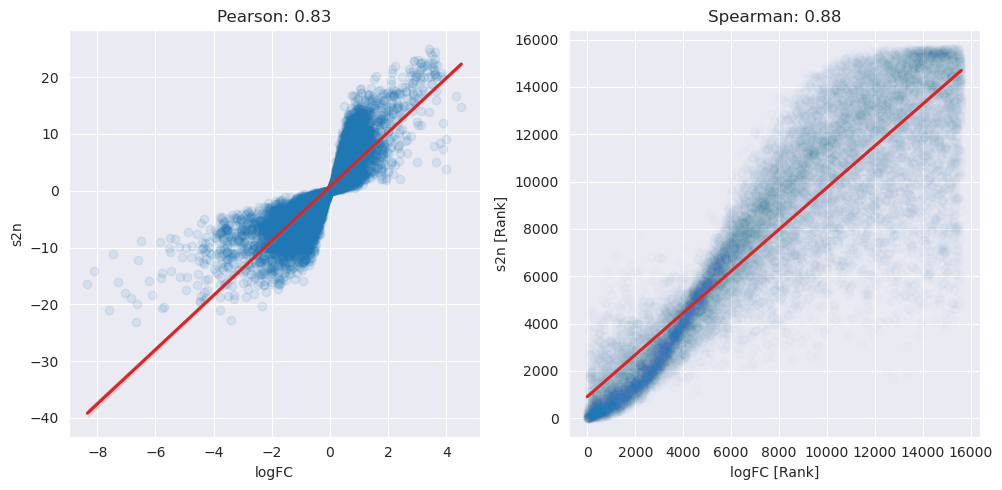

In [9]:
rank1 = "logFC"
rank2 = "s2n"

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Pearson correlation

correlation = df[rank1].corr(df[rank2], method='pearson')
sns.regplot(x=df[rank1], y=df["neg_signed_logpval"], ax=ax[0],
            scatter_kws={'alpha': 0.1}, line_kws={"color": palette[3]})
ax[0].set_title(f"Pearson: {correlation:.2f}")

ax[0].set(xlabel=rank1)
ax[0].set(ylabel=f"{rank2}")

# Spearman rank correlation

df['rank1'] = df[rank1].rank(method='average')
df['rank2'] = df[rank2].rank(method='average')
rank_correlation = df['rank1'].corr(df['rank2'], method='spearman')

sns.regplot(x=df['rank1'], y=df['rank2'], ax=ax[1],
            scatter_kws={'alpha': 0.01}, line_kws={"color": palette[3]})
ax[1].set_title(f"Spearman: {rank_correlation:.2f}")
fig.tight_layout()

ax[1].set(xlabel=f"{rank1} [Rank]")
ax[1].set(ylabel=f"{rank2} [Rank]")

# Run Snakemake

Run the cell below. 

Alternatively, run the following command in project root directory (more readable stdout):

`snakemake --use-conda --cores 1` (adjust number of cores as needed)

In [ ]:
from scripts.utils import run_snakemake

os.chdir("../..")
success = run_snakemake(cores=4, touch=False, dry=False)
os.chdir("./workflow/notebooks")
print("Succeeded:", success)

# Inspect results

## Load results

In [ ]:
import pickle
import matplotlib
from scripts.plots import npg_palette

npg = npg_palette()
output_files = glob.glob(f"{savepath}/syn.*[tc]sv")
print(f"Found {len(output_files)} output files:\n",*[o+"\n" for o in output_files])

summary_dict_file = f"{savepath}/combined/syn.summary_dict.{project_name}.txt"
with open(summary_dict_file, "rb") as f:
    summary_dict = pickle.load(f)

print("summary_dict loaded")
summary_dict.keys()

In [9]:
# In case another qval threshold should be used
# from scripts.combine_libs import create_summary_dict
# qval = 0.01
#summary_dict = create_summary_dict(f"{savepath}/combined",libraries,tools,metrics,project_name, qval=qval, save=False)

## Intersection depth

We count the number of unique analysis configuations (methods, rankings) each significant term appears in. We designate this as the *intersection depth* of a term. A depth of $N$ means that the corresponding enrichment term is significant in exactly $N$ configurations.

In [ ]:
from scripts.plots import make_bar_plots

make_bar_plots(summary_dict, figpath, project_name, lib_names, pretty_print=pretty_print, qval = qval, max_depth=max_depth)

## Venn diagrams

In [ ]:
from scripts.plots import make_venn_plots

make_venn_plots(summary_dict, figpath, project_name, lib_names, metrics, tools, pretty_print, qval = qval)

## UpSet plots

Useful for visualizing set intersection with more than 3 sets. 

https://upsetplot.readthedocs.io/en/stable/index.html

In [ ]:
from scripts.plots import make_upset_plots

make_upset_plots(summary_dict, lib_names, figpath, project_name, pretty_print)

## Lollipop

In [ ]:
from scripts.plots import make_lollipop_plots

make_lollipop_plots(summary_dict,
                        lib_names,
                        figpath,
                        project_name,
                        top_terms = 30,
                        qval = 0.05,
                        depth_cutoff = 6, 
                        max_depth = max_depth,
                        x_val = "NegSignedlogFDR",
                        hue_subontology=True,
                        split_by_subontology=True,
                        ext="png")

## Affected genes

In [ ]:
metric = "logFC"
lib = "KEGG"
lib = "GO"
tool = "gseapy"
tool = "string"
#tool = "clusterProfiler"

gene_table_file = f"../../results/{project_name}/gene_converter.csv"
converter = pd.read_csv(gene_table_file, index_col=0)

terms_dict = dict()

#terms = summary_dict[lib]["depth_df"].iloc[0]["Description"]

depth_df = pd.read_csv(f"{savepath}/combined/syn.depth.{lib}.{project_name}.csv", index_col=0)
d = depth_df
d = d[(d["Combined FDR"]<0.05) & (d["Depth"]>1)]
terms = d["Description"].values.tolist()

#terms = "E-box binding"

if not isinstance(terms, list): 
    terms = [terms]

terms = [t.strip() for t in terms]
terms.append("NADH dehydrogenase activity")

for t in terms:
    terms_dict[t] = None    

tab = pd.read_csv(f"{savepath}/syn.{tool}.{metric}.{lib}.{project_name}.csv", index_col=0)

not_found = []
for t in terms_dict:
    print(t)
    match tool:
        case "gseapy":
            lead_genes = tab.loc[t, "Lead_genes"]
            lead_genes = lead_genes.split(";")
        case "clusterProfiler":
            tt = tab[tab["Description"].str.lower()==t.lower()].index
            lead_genes = tab.loc[tt, "core_enrichment"]
            lead_genes = lead_genes.values[0].split("/")

        case "string":
            tt = tab[tab["Description"].str.lower()==t.lower()].index

            if "matching proteins in your input (labels)" in tab.columns:
                lead_genes = tab.loc[tt, "matching proteins in your input (labels)"]
            else:
                lead_genes = tab.loc[tt, "matching proteins in your input (IDs)"]
                
            try:
                lead_genes = lead_genes.values[0].split(",")
            except IndexError:
                print("Not found:", t)
                not_found.append(t)
                #display(tab.head())
        case default:
            assert 0
    terms_dict[t] = lead_genes

for n in not_found: del terms_dict[n]

dea = pd.read_csv("../../resources/Chiara/edger.qlf.lfc0.SA_WT.p1.csv", index_col=0)


##############

dd = depth_df[depth_df["Description"].str.contains("dehydrogenase")]
for d in dd.index:
    print(depth_df.loc[d,"Description"], depth_df.loc[d,"Configurations"])

dd

##############



from utils import ensp_to_gene_symbol
x = pd.read_csv("../../results/Chiara.QLF.SA_WT/proteins/chiara_list.csv")
x.columns = [x.strip().lower().replace(" - ","-") for x in x.columns]


for t in terms_dict:
    lead = terms_dict[t]

    if "ENSP0" in lead[0]:
        species = lead[0].split(".")[0]
        print(species)
        ensp = [le.split(species)[1][1:] for le in lead]
        converted = ensp_to_gene_symbol(ensp, species).values
    elif tool == "clusterProfiler":
        converted = converter[converter["ENTREZID"].astype(str).isin(terms_dict[t])]["SYMBOL"].values
    else:
        converted = lead

    d = dea[dea["gene_name"].isin(converted)]
    a = set(dea[dea["gene_name"].isin(converted)]["gene_name"])
    b = set(terms_dict[t])
    c = set(x[t.lower()].dropna())

    if "dehydrogenase" in t:
        # print(t, f"\nGenes in enrichment table: {len(terms_dict[t])}", f"\nedgeR table: {len(d)}")
        # print("Difference edger vs enrichment:", a.symmetric_difference(b))
        print(t, f"\nGenes in enrichment table: {len(terms_dict[t])}")
        print(f"Genes in Chiara's excel file: {len(c)}")
        print("Intersection enrichment & excel:", len(b.intersection(c)))
        print("Union enrichment & excel:", len(b.union(c)))
        print("In enrichment, missing in excel:", b.difference(c))
        print("In excel, missing in enrichment:", c.difference(b))
        print("\n============")
    
    d.to_csv(f"{savepath}/proteins/{t}.csv")

# Meta-analysis

Compare multiple datasets

In [4]:
import pickle
from scripts.plots import npg_palette

npg = npg_palette()

### PAPER

project_names = ["THCA.QLF","BRCA.QLF", "KIRC.QLF", "LIHC.QLF",
                 "Carmen.paired.QLF", 
                 "Chiara.QLF.KO_WT", "Chiara.QLF.SA_WT", "Chiara.QLF.SD_WT",
                 "met.Exc7_DL.P90.p19rc", "met.Inh_Sncg.P14.p19rc"]

pretty_datanames = {"BRCA.QLF":"TCGA.BRCA.N-T",
                    "THCA.QLF":"TCGA.THCA.N-T",
                    "KIRC.QLF":"TCGA.KIRC.N-T",
                    "LIHC.QLF":"TCGA.LIHC.N-T",
                    "met.Exc7_DL.P90.p19rc": "sn.Exc7.P90.WT-SA",
                    "met.Inh_Sncg.P14.p19rc": "sn.Inh.Sncg.P14.WT-SA",
                    "Chiara.QLF.KO_WT":"Ser1016.WT-KO",
                    "Chiara.QLF.SA_WT":"Ser1016.WT-SA",
                    "Chiara.QLF.SD_WT":"Ser1016.WT-SD",
                    "Carmen.paired.QLF":"CHK2.WT-KO"}

meta_savepath = "../../results/meta"
meta_project_name = "meta"

### MET

project_names = [
    "met.Astrocytes1.P14",
    "met.Astrocytes2.P14",
    "met.COPs.P14",
    "met.Endothelial.P14",
    "met.Exc1_SL.P14",
    "met.Exc2_ML.P14",
    "met.Exc3_ML.P14",
    "met.Exc4_ML.P14",  
    "met.Exc5_ML.P14",  
    "met.Exc6_ML.P14",
    "met.Exc7_DL.P14",
    "met.Exc8_DL.P14",
    "met.Exc9_DL.P14",
    "met.Inh_Lamp5.P14",
    "met.Inh_Meis2.P14",
    "met.Inh_Pvalb.P14",
    "met.Inh_Sst.P14",
    "met.Inh_Vip.P14",
    "met.MFO.P14",
    "met.Microglia.P14",
    "met.OPC.P14",

    "met.Astrocytes1.P90",
    "met.Endothelial.P90",
    "met.Exc1_SL.P90",
    "met.Exc2_ML.P90",
    "met.Exc3_ML.P90",
    "met.Exc6_ML.P90",
    "met.Exc7_DL.P90",
    "met.Exc8_DL.P90",
    "met.Exc9_DL.P90",
    "met.Inh_Lamp5.P90",
    "met.Inh_Meis2.P90",
    "met.Inh_Pvalb.P90",
    "met.Inh_Sst.P90",
    "met.Inh_Vip.P90",
    "met.MFO.P90",
    "met.Microglia.P90",
    "met.OPC.P90"
]

meta_savepath = "../../results/meta.met"
meta_project_name = "meta.met"

pretty_datanames = {p: p.split("met.")[1] for p in project_names}

meta_dict = dict()
for project in project_names:
    try:
        with open(f"../../results/{project}/combined/syn.summary_dict.{project}.txt", "rb") as f:
            meta_dict[project] = pickle.load(f)
    except FileNotFoundError:
        print(f"Project not found: {project}")

npg

[(0.9019607843137255, 0.29411764705882354, 0.20784313725490197),
 (0.30196078431372547, 0.7333333333333333, 0.8352941176470589),
 (0.0, 0.6274509803921569, 0.5294117647058824),
 (0.23529411764705882, 0.32941176470588235, 0.5333333333333333),
 (0.9529411764705882, 0.6078431372549019, 0.4980392156862745),
 (0.5176470588235295, 0.5686274509803921, 0.7058823529411765),
 (0.5686274509803921, 0.8196078431372549, 0.7607843137254902),
 (0.8627450980392157, 0.0, 0.0),
 (0.49411764705882355, 0.3803921568627451, 0.2823529411764706),
 (0.6901960784313725, 0.611764705882353, 0.5215686274509804)]

In [5]:
meta_summary_dict = dict()

for lib in lib_names:
    meta_summary_df = []
    for project in meta_dict:
        df = meta_dict[project][lib]["summary_df"]
        df.index = df.index + "." + project # needed for venn
        meta_summary_df.append(df)

    meta_summary_df = pd.concat(meta_summary_df)
    meta_summary_dict[lib] = dict()
    meta_summary_dict[lib]["summary_df"] = meta_summary_df

    meta_depth_df = []
    for project in meta_dict:
        depth_df_p = meta_dict[project][lib]["depth_df"]
        depth_df_p["Project"] = project
        depth_df_p.replace({"Project":pretty_datanames}, inplace=True)
        meta_depth_df.append(depth_df_p)

    meta_depth_df = pd.concat(meta_depth_df)
    meta_summary_dict[lib]["depth_df"] = meta_depth_df

In [ ]:
from matplotlib_venn import venn3

d = meta_summary_dict["GO_STRING_mouse"]["depth_df"]
dd = d.reset_index()
dd = dd.loc[dd["Top_GO_Cluster"].dropna().index]

fig, ax = plt.subplots(1,1)
venn3((set(dd["index"]), set(dd[dd["Enrichr"]]["index"]), set(dd[dd["Top_GO_Cluster"]]["index"])),
      set_labels=["All","Enrichr","GOSemSim"], ax=ax)

fig.savefig(f"{meta_savepath}/venn3.goterms.pdf")

In [7]:
# import matplotlib

# palette = npg

# sns.set(font_scale=1.2)
# #sns.set_style("whitegrid")
# sns.set_style("ticks")

# fig, axes = plt.subplots(2, 2, figsize=(10,10))
# axes = axes.flatten()

# ### Intersection depth

# for ax, lib in zip(axes[:2],meta_depth_dict):
#     sns.despine()
#     depth_df = meta_depth_dict[lib]
#     h = sns.histplot(depth_df['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
#                 discrete=True, ax=ax, alpha=1, color=npg[3], label="Non-TCGA")
#     h.bar_label(h.containers[0])
#     ax.set(title=lib, xlabel="Intersection Depth", ylabel="Terms")
#     ax.set_xticks(range(depth_df['Depth'].min(), depth_df['Depth'].max() + 1))
#     ax.grid(axis='x')

#     ### plot TCGA only on top
#     TCGA = depth_df[depth_df["Project"].str.startswith("TCGA")]
#     sns.histplot(TCGA['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
#                 discrete=True, ax=ax, alpha=1, color=npg[5], label="TCGA")
    
#     ### label bars    
#     nonTCGA = depth_df[~depth_df["Project"].str.startswith("TCGA")]
#     nonTCGA_counts = nonTCGA['Depth'].value_counts().sort_index()
#     TCGA_counts = TCGA['Depth'].value_counts().sort_index()
#     for i in range(depth_df["Depth"].max()):
#         ax.text(s=TCGA_counts.iloc[i], x=i+1,y=TCGA_counts.iloc[i]/2,  va='center',ha='center')
#         ax.text(s=nonTCGA_counts.iloc[i], x=i+1,y=TCGA_counts.iloc[i]+nonTCGA_counts.iloc[i]/2,  va='center',ha='center',color="white")

#     ax.legend(loc="best")
#     ax.grid(False)

#     if ax == axes[0]:
#         pass#ax.set_ylim(0,349)

# ### Number of terms

# for ax, lib in zip(axes[2:], meta_summary_dict):
#     sns.despine()
#     summary_df = meta_summary_dict[lib]
#     qv = summary_df.drop(["Combined","nan"], axis=1, level=0)
#     qv = qv.xs("qvalue", level=2, axis=1)
#     qv = qv.replace(np.nan,1)
#     qv = qv < qval

#     qqv=qv.sum().reset_index()
#     qqv.replace({"Tool": pretty_print, "Metric": pretty_print}, inplace=True)
#     qqv.index = qqv["Tool"] + "\n" + qqv["Metric"]
#     qqv = qqv.drop(["Tool","Metric"], axis=1)
#     qqv = qqv.sort_values(by=qqv.columns[0], ascending=False)

#     if ax == axes[2]:
#         hue_order = {qqv.index[i]: npg[i] for i in range(len(qqv))}

#     qqv["hue"] = qqv.index
#     b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)
#     for i in b.containers:
#         b.bar_label(i,)
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=60, ha='right')
#     ax.set(title=lib, ylabel="Terms", xlabel=None)

#     # apply offset transform to all x ticklabels.
#     offset = matplotlib.transforms.ScaledTranslation(12/72., 3/72., fig.dpi_scale_trans)
#     for label in ax.xaxis.get_majorticklabels():
#         label.set_transform(label.get_transform() + offset)
        
# for i in range(len(axes)):
#     axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)

# fig.tight_layout()
# fig.savefig(os.path.join(meta_savepath, "bars.meta.pdf"))

In [ ]:
from scripts.plots import make_bar_plots

make_bar_plots(summary_dict=meta_summary_dict,
               figpath = meta_savepath,
                    project_name =  meta_project_name,
                    lib_names = lib_names,
                    pretty_print = pretty_print,
                    qval = 0.05,
                    palette = npg_palette(),
                    max_depth = max_depth,
                    ext = "png")


['clusterProfiler', 'gseapy', 'string'] logFC
['clusterProfiler', 'gseapy', 'string'] neg_signed_logpval
['clusterProfiler', 'gseapy', 'string'] s2n
['clusterProfiler', 'gseapy', 'string'] logFC
['clusterProfiler', 'gseapy', 'string'] neg_signed_logpval
['clusterProfiler', 'gseapy', 'string'] s2n


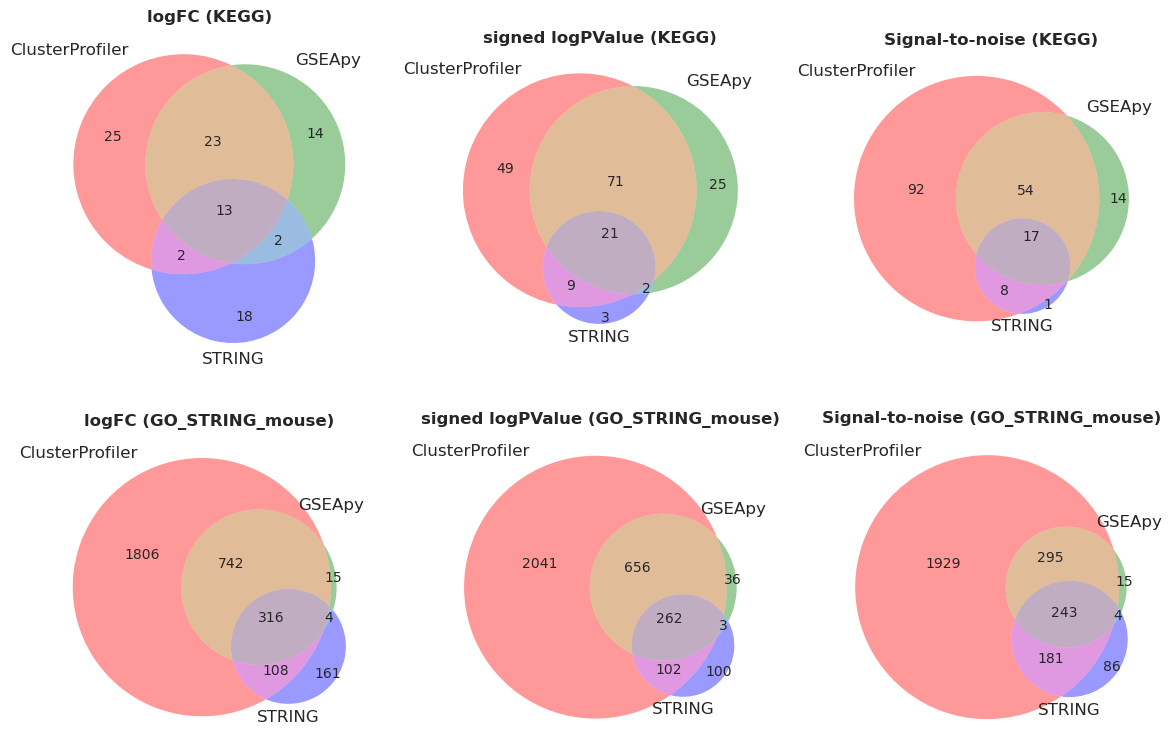

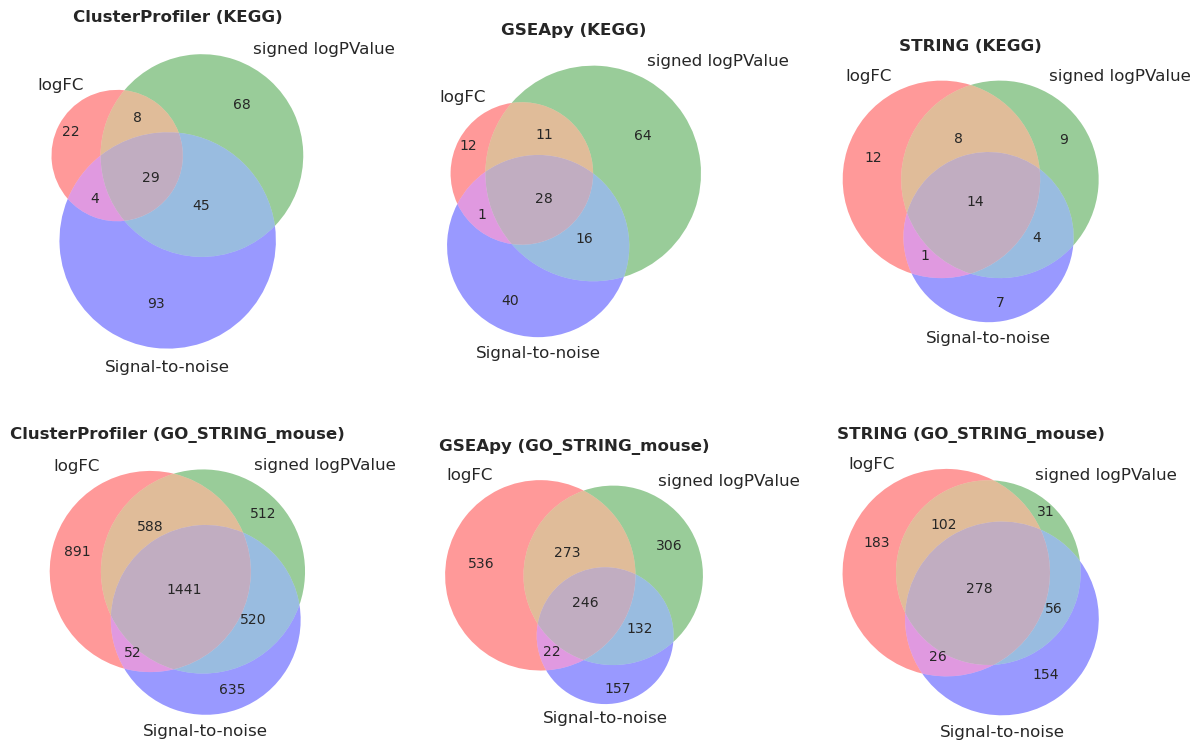

In [147]:
from scripts.plots import make_venn_plots

make_venn_plots(summary_dict = meta_summary_dict, 
                    figpath = meta_savepath,
                    project_name = meta_project_name,
                    lib_names = lib_names,
                    metrics = metrics,
                    tools = tools,
                    pretty_print = pretty_print,
                    qval = 0.05,
                    ext = "png")

In [ ]:
from scripts.plots import make_upset_plots

make_upset_plots(summary_dict = meta_summary_dict, 
                    lib_names = lib_names,
                    figpath = meta_savepath,
                    project_name = meta_project_name,
                    pretty_print = pretty_print,
                    ext = "png")

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()

fig, axes = plt.subplots(2, 2, figsize=(12+len(project_names)//3, 10))
axes = axes.flatten()

### Number of terms per dataset

for ax, lib in zip(axes[:2],lib_names):
    sns.despine()
    depth_df = meta_summary_dict[lib]["depth_df"]
    depth_df.replace({"Project":pretty_datanames}, inplace=True)

    counts = depth_df.groupby(["Project"]).count()["Configurations"].sort_values(ascending=False)

    counts = pd.DataFrame(counts)

    counts["hue"] = counts.index
    #counts.replace({"hue":pretty_datanames}, inplace=True)

    if ax == axes[0]:
        hue_order = {counts.iloc[i]["hue"]: npg[i%len(npg)] for i in range(len(counts))}
        
    b = sns.barplot(data=counts, y="Configurations", x="hue", ax=ax, hue="hue", hue_order=hue_order, palette=npg[:len(project_names)])
    ax.set(title=lib,xlabel=None,ylabel="Combined Terms")

    for i in b.containers:
        b.bar_label(i,)

    # if ax == axes[1]:
    #     ax.set_ylim(0,2999)
    
    # if ax == axes[0]:
    #     ax.set_ylim(0,199)

    # mark depths with horzontal lines
    g = depth_df.groupby(["Project"])["Depth"].value_counts()
    for j, p in enumerate(counts.index):
        sum = 0
        prev_sum = 0
        maxdepth = g.index.get_level_values("Depth").max()
        for i in range(1,1+maxdepth):
            try:
                sum += g.loc[(p,i)]
            except KeyError:
                pass
            if i < maxdepth:
                ax.scatter(j, sum, marker="_", color="black", s=550, alpha=0.5)
            if j == 0:
                ax.text(s=f"d{i}",x=j,y=prev_sum + 0.5*(sum-prev_sum), ha="center", va="center",fontsize=10)
            prev_sum = sum

for ax, lib in zip(axes[2:], lib_names):
    depth_df = meta_summary_dict[lib]["depth_df"]
    #depth_df.replace({"Project":pretty_datanames}, inplace=True)
    #sns.barplot(data=depth_df, x="Project", y="Depth", hue="Project", errorbar="sd", ax=ax, order=hue_order.keys(), hue_order=hue_order, palette=npg[:len(project_names)])
    sns.boxplot(data=depth_df, x="Project", y="Depth", hue="Project", ax=ax, order=hue_order.keys(), hue_order=hue_order, palette=npg[:len(project_names)])
    ax.set(ylabel="Enrichment Depth",title=lib)

    if ax == axes[3]:
        ax.set_ylim(axes[2].get_ylim())

for i in range(len(axes)):
    axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)
    axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=30, ha='right')
    axes[i].set(xlabel=None)

    # annotate KI
    # axes[i].axvline(len(pretty_datanames)-4.5,0,axes[i].get_ylim()[1],ls="--",color="black",alpha=0.7)
    #axes[i].annotate("KI", xy=(0,0), xytext=(len(pretty_datanames)-3, 0.8*axes[i].get_ylim()[1] ), xycoords="data",zorder=99)

    # if i == 0:
    #     axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.8), xycoords="axes fraction",zorder=99)
    # elif i == 1:
    #     axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.735), xycoords="axes fraction",zorder=99)
    # elif i == 2:
    #     axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.84), xycoords="axes fraction",zorder=99)
    # else:
    #     axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.84), xycoords="axes fraction",zorder=99)

fig.tight_layout()
fig.savefig(f"{meta_savepath}/bars.data.meta.png")

In [ ]:
golib = "GO_STRING_mouse"
d = meta_summary_dict[golib]["depth_df"]
d["n_genes"] = d["Genes"].str.split(";").apply(lambda x: len(x))
d["logFDR"] = -np.log10(d["Combined FDR"])
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

sns.violinplot(data=d, x="Direction", y="Depth", ax=ax[0])
ax[0].set(xlabel="Direction", ylabel="Robustness")

sns.violinplot(data=d, x="ONTOLOGY", y="Depth", ax=ax[1])
ax[1].set(xlabel="Domain", ylabel="Robustness")

sns.violinplot(data=d, x="Enrichr", y="Depth", ax=ax[2])
ax[2].set(xlabel="Enrichr", ylabel="Robustness")

sns.violinplot(data=d, x="Depth", y="n_genes", ax=ax[3])
ax[3].set(xlabel="Robustness", ylabel="# Genes in Term")

sns.violinplot(data=d, x="Depth", y="logFDR", ax=ax[4])
ax[4].set(xlabel="Robustness", ylabel="-log10 FDR")

sns.violinplot(data=d, x="Enrichr", y="n_genes", ax=ax[5])
ax[5].set(xlabel="Enrichr", ylabel="# Genes in Term")

fig.suptitle(golib)
fig.tight_layout()
fig.savefig(f"{meta_savepath}/violin.meta.png")

## Inter-project term heatmaps

In [20]:
depth_cutoff = 6
lib = "GO_STRING_mouse"

projects = meta_dict.keys()
#projects = [p for p in projects if "P14" in p]

inter_mat = pd.DataFrame(index=projects, columns=projects, dtype=float)
union_mat = pd.DataFrame(index=projects, columns=projects, dtype=float)
jacc_mat = pd.DataFrame(index=projects, columns=projects, dtype=float)

for p1 in projects:
    for p2 in projects:
        
        d1 = meta_dict[p1][lib]["depth_df"]
        if len(d1) < 1:
            dc1 = set()
        else:
            dc1 = d1[d1["Depth"]>depth_cutoff]
            dc1 = dc1.index.astype(str) + "_" + dc1["Direction"]
            dc1 = set(dc1)


        d2 = meta_dict[p2][lib]["depth_df"]
        if len(d2) < 1:
            dc2 = set()
        else:
            dc2 = d2[d2["Depth"]>depth_cutoff]
            dc2 = dc2.index.astype(str) + "_" + dc2["Direction"]
            dc2 = set(dc2)

        inter = dc1.intersection(dc2)
        inter_mat.loc[p1,p2] = len(inter)

        union = dc1.union(dc2)
        union_mat.loc[p1,p2] = len(union)

        jacc = (len(inter) / len(union) ) if len(union) else 0
        jacc_mat.loc[p1,p2] = jacc

In [ ]:
y = int(len(jacc_mat)*0.6)
x = int(1.2*y)

fig, ax = plt.subplots(1,1,figsize=(x,y))

#mask = jacc_mat.applymap(lambda x: '•' if x < 0.01 else f'{x:.2f}')
mask1 = inter_mat.map(lambda x: '•' if x == 0 else f'{int(x)}')
mask2 = union_mat.map(lambda x: '•' if x == 0 else f'{int(x)}')
mask3 = mask1 + "\n" + mask2
mask3 = mask3.map(lambda x: '•' if x.startswith("•") else x)

h = sns.heatmap(jacc_mat,  annot=mask3.values, ax=ax, fmt="")
fig.axes[1].set(title="Jaccard", xlabel='', ylabel='')

ax.set_xticklabels([label.get_text().replace('met.', '') for label in ax.get_xticklabels()])
ax.set_yticklabels([label.get_text().replace('met.', '') for label in ax.get_yticklabels()])

fig.suptitle(f"Intersection/Union of significant terms with same direction\n{lib} | Depth>{depth_cutoff}")

fig.tight_layout()
fig.savefig(f"{meta_savepath}/heat.meta.depth{depth_cutoff}.png")

## Inter-configuration heat maps

In [6]:
project = "met.Inh_Meis2.P14"
lib = "GO_STRING_mouse"

df = meta_dict[project][lib]["depth_df"]
df = df.assign(Configurations=df["Configurations"].str.split(";")).explode("Configurations")
df["Configurations"] = df["Configurations"].str.strip()
d1 = df[["Configurations","Direction"]]
configurations = sorted(list(set(df["Configurations"])))

inter_mat = pd.DataFrame(index=configurations, columns=configurations, dtype=float)
union_mat = pd.DataFrame(index=configurations, columns=configurations, dtype=float)
jacc_mat = pd.DataFrame(index=configurations, columns=configurations, dtype=float)

for c1 in configurations:
    for c2 in configurations:

        dc1 = d1[d1["Configurations"]==c1]
        dc1 = dc1.index.astype(str) + "_" + dc1["Direction"]
        dc1 = set(dc1)

        dc2 = d1[d1["Configurations"]==c2]
        dc2 = dc2.index.astype(str) + "_" + dc2["Direction"]
        dc2 = set(dc2)


        inter = dc1.intersection(dc2)
        inter_mat.loc[c1,c2] = len(inter)

        union = dc1.union(dc2)
        union_mat.loc[c1,c2] = len(union)

        jacc = (len(inter) / len(union) ) if len(union) else 0
        jacc_mat.loc[c1,c2] = jacc

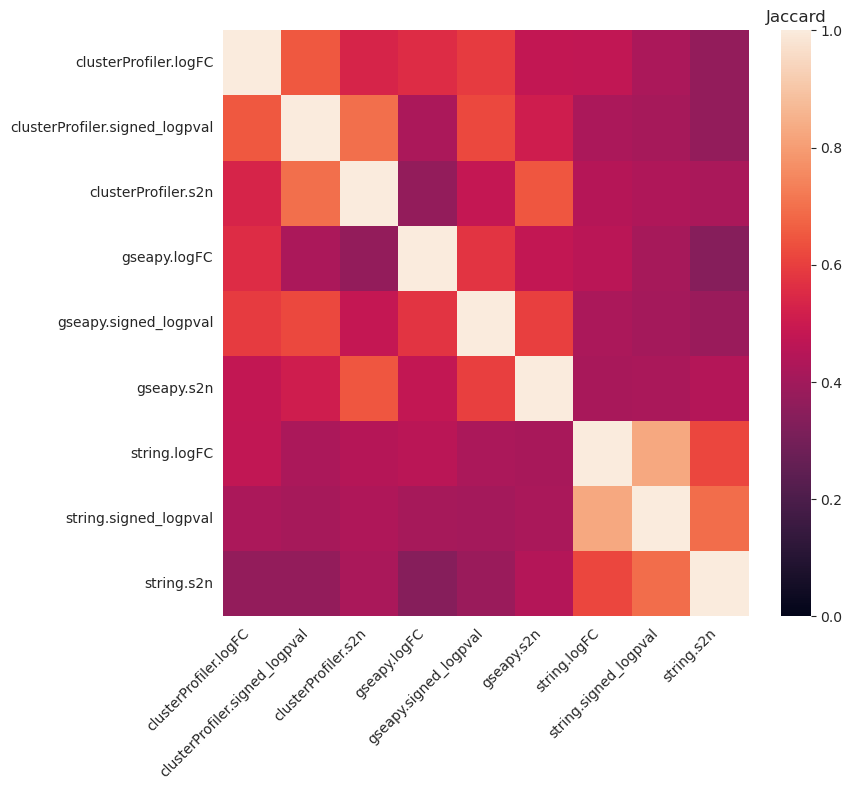

In [7]:
import colorcet as cc
#cmap = cc.diverging_rainbow_bgymr_45_85_c67

y = int(len(jacc_mat)*0.6*1.5)
x = int(1.2*y)

fig, ax = plt.subplots(1,1,figsize=(x,y))

mask1 = inter_mat.map(lambda x: '•' if x == 0 else f'{int(x)}')
mask2 = union_mat.map(lambda x: '•' if x == 0 else f'{int(x)}')
mask3 = mask1 + "\n" + mask2
mask3 = mask3.map(lambda x: '•' if x.startswith("•") else x)

clean = True
if clean:
    mask3 = mask3.map(lambda x: '')

h = sns.heatmap(jacc_mat, ax=ax, fmt="", annot=mask3.values, vmin=0)#, cmap=cmap)
fig.axes[1].set(title="Jaccard", xlabel='', ylabel='')

ax.set_xticklabels([label.get_text().replace('met.', '') for label in ax.get_xticklabels()])
ax.set_yticklabels([label.get_text().replace('met.', '') for label in ax.get_yticklabels()])

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xticks(ax.get_xticks(), [l.get_text().replace("neg_","") for l in ax.get_xticklabels()], rotation=45, ha='right')
ax.set_yticks(ax.get_yticks(), [l.get_text().replace("neg_","") for l in ax.get_yticklabels()])


#fig.suptitle(f"Intersection/Union of significant terms with same direction\n{lib}")
fig.tight_layout()

if clean:
    fig.savefig(f"{meta_savepath}/heat.meta.configs.clean.png")
else:
    fig.savefig(f"{meta_savepath}/heat.meta.configs.png")

## Bulk plots

Quickly re-plot multiple projects

In [ ]:
from scripts.plots import make_lollipop_plots

for project in meta_dict:

    summary_dict_p = meta_dict[project]
    figpath_p = os.path.join("../../", f"results/{project}/figures")

    to_split = ["met.Astrocytes2.P14","met.Inh_Meis2.P14","met.Exc3_ML.P90"]
    split_by_subontology = any([s in project for s in to_split])
    if not split_by_subontology: continue

    make_lollipop_plots(summary_dict_p,
                            lib_names,
                            figpath_p,
                            project,
                            top_terms = 30,
                            qval = 0.05,
                            depth_cutoff = 6, 
                            max_depth = max_depth,
                            x_val = "NegSignedlogFDR",
                            hue_subontology=True,
                            split_by_subontology=split_by_subontology,
                            ext="png")

# Utilities

## STRING

### Format STRING table

User can (optionally) manually add [STRING](https://string-db.org/cgi/input?sessionId=b9myRH3ZDO2O&input_page_active_form=proteins_with_values) functional scoring output tables to the results folder, and they will be combined with the output from SynEnrich. For this, STRING tables have to be formatted first:

1) Download the .tsv file from the STRING web tool and save it in `results/{project_name}`.

2) Rename the file to `syn.string.{metric}.{project_name}.tsv` where {metric} is to be replaced with the ranking metric (e.g. logFC) and {project_name} with the project name specified at the beginning of this notebook.

3) Use the cell below to format the STRING table (which will split the file in separate KEGG and GO tables and rename some columns)

In [20]:
from scripts.utils import format_string_table

string_file1 = f"{savepath}/syn.string.logFC.{project_name}.tsv"
string_file2 = f"{savepath}/syn.string.neg_signed_logpval.{project_name}.tsv"
string_file3 = f"{savepath}/syn.string.s2n.{project_name}.tsv"

string_files = [string_file1, string_file2, string_file3]
string_files = [string_file3]

for string_file in string_files:

    string = pd.read_csv(string_file, index_col=0, sep="\t")

    for library in libraries:
        lib = "GO" if library.startswith("GO") else library
        if library.endswith(".gmt"): library = library[:-4]
        string_formatted = format_string_table(string, lib)
        #display(string_formatted.head())
        string_formatted.to_csv(string_file.replace(f"{project_name}.tsv", f"{library}.{project_name}.csv"))

### Prepare STRING upload

The cell below can be used to split the input table into several files for each ranking metric, which is convenient for uploading to STRING.


In [19]:
df = pd.read_csv("../../"+input_file, index_col=0)
p = "../../" + "/".join(input_file.split("/")[:-1])
name = input_file.split("/")[-1]
for metric in metrics:
    print(len(df[metric]))
    df[metric] = df[metric].dropna()
    print(len(df))
    df[metric].to_csv(os.path.join(p,f"string.input.{metric}."+name), header=False)

18952
18952
18952
18952
18952
18952


### Create STRING gmt file

The cell below can be used to format a txt file with enrichment terms [downloaded from STRING](https://string-db.org/cgi/download?sessionId=b26FUyLIdNfn) into a `.gmt` file.

In [9]:
from scripts.utils import create_string_gmt

infile = "../../resources/Ontologies/9606.protein.enrichment.terms.v12.0.tsv" #human 
#infile = "../../resources/Ontologies/10090.protein.enrichment.terms.v12.0.txt" #mouse

orgid = os.path.basename(infile).split(".")[0]
orgid_dict = {"9606": "human", "10090": "mouse"}
species = orgid_dict[orgid]
print(orgid, species)

outfile = f'../../resources/Ontologies/GO_STRING_{species}.gmt'

create_string_gmt(infile, outfile, orgid, "")

9606 human
Retrieving gene symbols...
quering for 9606
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-18876...done.
Finished.
374 input query terms found no hit:
	['ENSP00000431914', 'ENSP00000485952', 'ENSP00000405899', 'ENSP00000483567', 'ENSP00000389715', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [ ]:
# import scripts.plots
# import importlib
# importlib.reload(scripts.plots)